\## Лабораторная работа №1 (KNN)

Для задачи классификации выбран датасет Credit Card Customers, содержащий данные о клиентах банка, где целевой переменной является факт оттока клиента. Это актуальная бизнес-задача, так как удержание клиентов обходится дешевле привлечения новых, и прогнозирование оттока позволяет своевременно принять меры лояльности. Для задачи регрессии выбран датасет Flight Fare Prediction, содержащий информацию о перелетах, где целевой переменной является цена билета. Прогнозирование динамического ценообразования критически важно для авиакомпаний и агрегаторов путешествий для оптимизации прибыли и предложения конкурентных цен. В качестве метрик для классификации выбраны F1-score (так как данные об оттоке часто несбалансированы и важен баланс точности и полноты) и ROC-AUC (для оценки качества ранжирования вероятностей). Для регрессии выбраны MAE (средняя абсолютная ошибка, интерпретируемая в валюте), RMSE (штрафует за большие отклонения) и R2 (коэффициент детерминации для оценки объясненной дисперсии).

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist
from scipy.stats import mode
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

Загрузим датасеты

In [3]:
df_class = pd.read_csv('BankChurners.csv')
cols_to_drop = [c for c in df_class.columns if 'Naive_Bayes' in c] + ['CLIENTNUM']
df_class = df_class.drop(columns=cols_to_drop)

df_reg = pd.read_excel('Data_Train.xlsx')

print("Датасеты успешно загружены.")
print(f"Размер датасета классификации: {df_class.shape}")
print(f"Размер датасета регрессии: {df_reg.shape}")

Датасеты успешно загружены.
Размер датасета классификации: (10127, 20)
Размер датасета регрессии: (10683, 11)


Обучим базовые модели KNN из библиотеки sklearn. Мы удалим строки с пропусками (если они есть), а категориальные признаки закодируем самым простым способом (Label Encoding), чтобы алгоритм KNN мог работать с евклидовым расстоянием. Это даст нам отправную точку для сравнения. Для классификации целевой переменной является 'Attrition_Flag', для регрессии — 'Price'.

In [4]:
df_class_base = df_class.copy()
le = LabelEncoder()

for col in df_class_base.select_dtypes(include='object').columns:
    df_class_base[col] = le.fit_transform(df_class_base[col])

X_class = df_class_base.drop('Attrition_Flag', axis=1)
y_class = df_class_base['Attrition_Flag']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_c, y_train_c)
y_pred_c = knn_clf.predict(X_test_c)
y_prob_c = knn_clf.predict_proba(X_test_c)[:, 1]

df_reg_base = df_reg.dropna().copy()

for col in df_reg_base.select_dtypes(include='object').columns:
    df_reg_base[col] = le.fit_transform(df_reg_base[col].astype(str))

X_reg = df_reg_base.drop('Price', axis=1)
y_reg = df_reg_base['Price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_r, y_train_r)
y_pred_r = knn_reg.predict(X_test_r)

print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c):.4f}")
print(f"F1 Score (macro): {f1_score(y_test_c, y_pred_c, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c):.4f}")
print("\n")

print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_r, y_pred_r):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_r)):.2f}")
print(f"R2 Score: {r2_score(y_test_r, y_pred_r):.4f}")

Классификация
Accuracy: 0.8899
F1 Score (macro): 0.7753
ROC AUC: 0.8770


Регрессия
MAE: 1839.05
RMSE: 3039.53
R2 Score: 0.5715


F1 Macro (0.78) — заметно ниже Accuracy. Это подтверждает, что модель хуже справляется с минорным классом (ушедшими клиентами). А R2 работает не лучше подбрасывания монетки. Причина кроется в том, что мы подали KNN "сырые" данные. Даты и время были закодированы как простые числа (Label Encoding), что убило всю логику времени (расстояние между "10:00" и "20:00" для KNN стало бессмысленным).

## Улучшение бейзлайна

Визуализируем данные.
Для классификации мы посмотрим на матрицу корреляций, чтобы убрать лишние признаки и распределение целевой переменной, чтобы подтвердить дисбаланс.
Для регрессии мы посмотрим на зависимость цены от авиакомпании (категориальный признак) и на распределение самой цены, чтобы увидеть выбросы. Также сделем предварительную обработку дат только для графиков, чтобы показать зависимость цены от месяца.

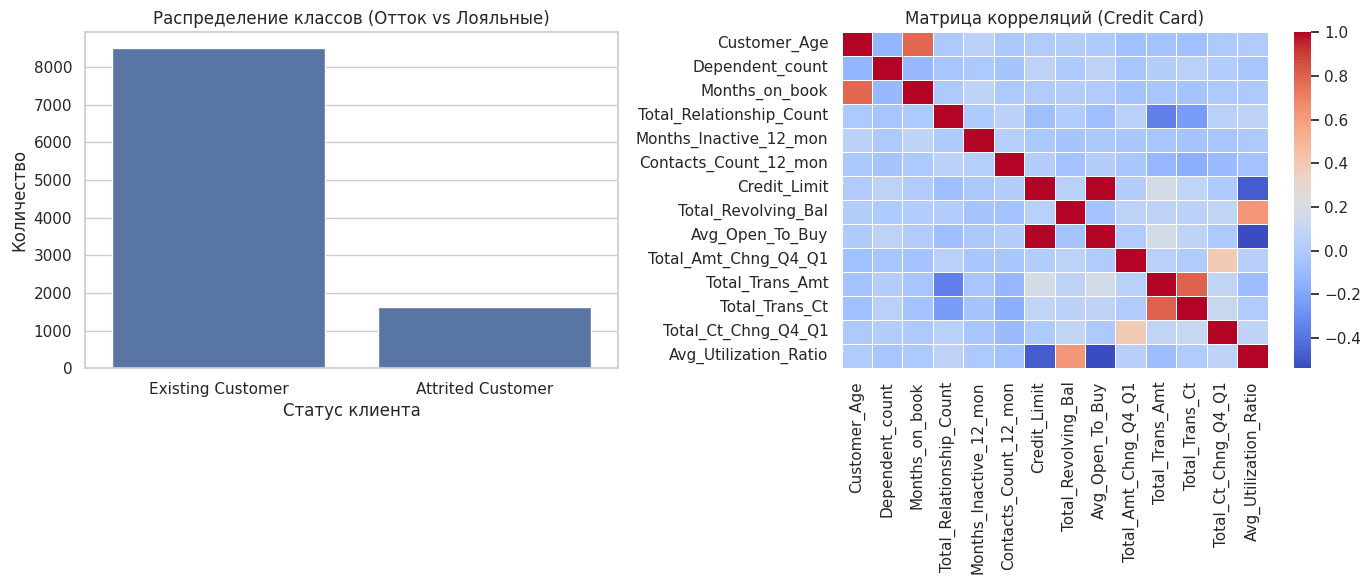

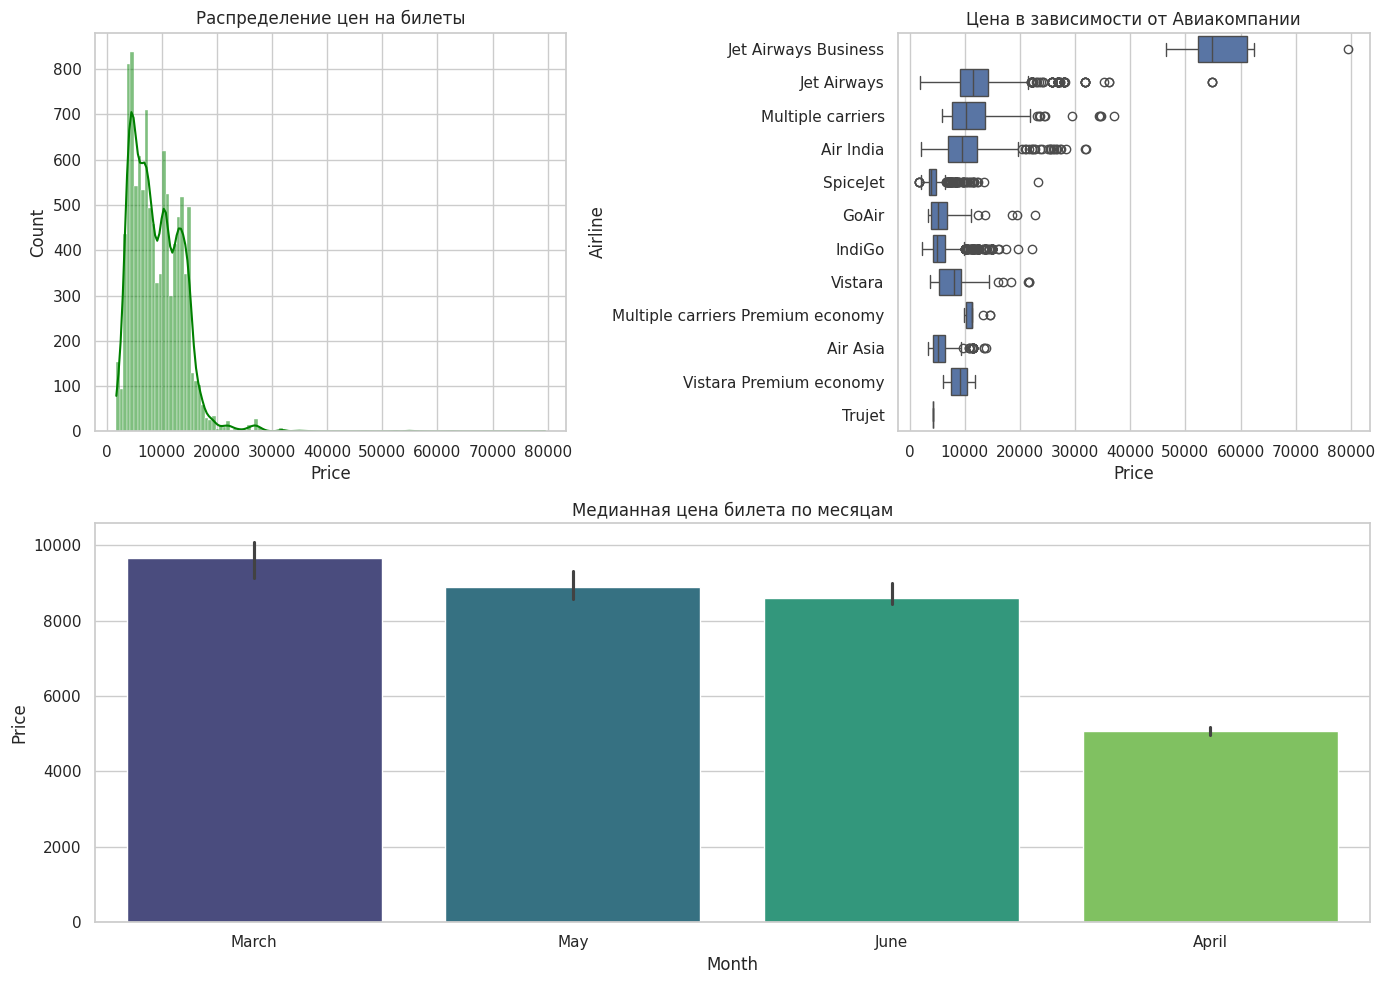

In [5]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Attrition_Flag', data=df_class)
plt.title('Распределение классов (Отток vs Лояльные)')
plt.xlabel('Статус клиента')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
numeric_cols = df_class.select_dtypes(include=[np.number]).columns
corr_matrix = df_class[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляций (Credit Card)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(df_reg['Price'], kde=True, color='green')
plt.title('Распределение цен на билеты')

plt.subplot(2, 2, 2)
sns.boxplot(x='Price', y='Airline', data=df_reg.sort_values("Price", ascending=False))
plt.title('Цена в зависимости от Авиакомпании')


df_reg_viz = df_reg.copy()
df_reg_viz['Date_of_Journey'] = pd.to_datetime(df_reg_viz['Date_of_Journey'], dayfirst=True)
df_reg_viz['Month'] = df_reg_viz['Date_of_Journey'].dt.month_name()

plt.subplot(2, 1, 2)
sns.barplot(x='Month', y='Price', data=df_reg_viz, estimator=np.median, palette='viridis')
plt.title('Медианная цена билета по месяцам')

plt.tight_layout()
plt.show()

Для классификации ключевыми проблемами являются сильный дисбаланс классов и мультиколлинеарность признаков, что ухудшает работу KNN. Решение включает балансировку, удаление избыточных признаков, масштабирование с помощью StandardScaler, замену Label Encoding на One-Hot Encoding и настройку весов соседей. В регрессии основные сложности создают выбросы в цене, скошенное распределение целевой переменной и сезонность. Для улучшения модели попробуем логарифмирование цены, выделение отдельных признаков из даты и времени, преобразование длительности перелета в минуты, масштабирование признаков и последующий подбор оптимального числа соседей через GridSearchCV. Исключение шума пока что делать не будем, так как по идее должно сработать хорошо



In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


X_class_imp = df_class.drop(['Attrition_Flag', 'Avg_Open_To_Buy'], axis=1)
y_class_imp = df_class['Attrition_Flag']
y_class_imp = y_class_imp.apply(lambda x: 1 if x == 'Attrited Customer' else 0)

num_cols_c = X_class_imp.select_dtypes(include=np.number).columns
cat_cols_c = X_class_imp.select_dtypes(include='object').columns

preprocessor_c = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_c),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_c)
    ])

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class_imp, y_class_imp, test_size=0.2, random_state=42)

knn_pipe_c = Pipeline([
    ('preprocessor', preprocessor_c),
    ('knn', KNeighborsClassifier())
])

param_grid_c = {
    'knn__n_neighbors': [3, 5, 7, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid_c = GridSearchCV(knn_pipe_c, param_grid_c, cv=3, scoring='f1_macro', n_jobs=-1)
grid_c.fit(X_train_c, y_train_c)

best_model_c = grid_c.best_estimator_
y_pred_c_imp = best_model_c.predict(X_test_c)
y_prob_c_imp = best_model_c.predict_proba(X_test_c)[:, 1]



df_reg_imp = df_reg.dropna().copy()

df_reg_imp['Journey_Day'] = pd.to_datetime(df_reg_imp.Date_of_Journey, format="%d/%m/%Y").dt.day
df_reg_imp['Journey_Month'] = pd.to_datetime(df_reg_imp.Date_of_Journey, format="%d/%m/%Y").dt.month
df_reg_imp.drop('Date_of_Journey', axis=1, inplace=True)

df_reg_imp['Dep_Hour'] = pd.to_datetime(df_reg_imp['Dep_Time']).dt.hour
df_reg_imp['Dep_Min'] = pd.to_datetime(df_reg_imp['Dep_Time']).dt.minute
df_reg_imp.drop('Dep_Time', axis=1, inplace=True)

df_reg_imp['Arrival_Hour'] = pd.to_datetime(df_reg_imp['Arrival_Time']).dt.hour
df_reg_imp['Arrival_Min'] = pd.to_datetime(df_reg_imp['Arrival_Time']).dt.minute
df_reg_imp.drop('Arrival_Time', axis=1, inplace=True)

def convert_duration(duration):
    h, m = 0, 0
    parts = duration.split()
    for part in parts:
        if 'h' in part:
            h = int(part[:-1])
        if 'm' in part:
            m = int(part[:-1])
    return h * 60 + m

df_reg_imp['Duration_Mins'] = df_reg_imp['Duration'].apply(convert_duration)
df_reg_imp.drop('Duration', axis=1, inplace=True)

stops_map = {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}
df_reg_imp['Total_Stops'] = df_reg_imp['Total_Stops'].map(stops_map)

df_reg_imp.drop(['Route', 'Additional_Info'], axis=1, inplace=True)

X_reg_imp = df_reg_imp.drop('Price', axis=1)
y_reg_imp = np.log1p(df_reg_imp['Price'])

num_cols_r = X_reg_imp.select_dtypes(include=np.number).columns
cat_cols_r = X_reg_imp.select_dtypes(include='object').columns

preprocessor_r = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_r),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_r)
    ])

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_imp, y_reg_imp, test_size=0.2, random_state=42)

knn_pipe_r = Pipeline([
    ('preprocessor', preprocessor_r),
    ('knn', KNeighborsRegressor())
])

param_grid_r = {
    'knn__n_neighbors': [3, 5, 7, 10, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid_r = GridSearchCV(knn_pipe_r, param_grid_r, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_r.fit(X_train_r, y_train_r)

best_model_r = grid_r.best_estimator_

y_pred_log = best_model_r.predict(X_test_r)
y_pred_final = np.expm1(y_pred_log)
y_test_final = np.expm1(y_test_r)


print(f"Лучшие параметры Классификации: {grid_c.best_params_}")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_imp):.4f}")
print(f"F1 Score (macro): {f1_score(y_test_c, y_pred_c_imp, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c_imp):.4f}")

print(f"Лучшие параметры Регрессии: {grid_r.best_params_}")
print(f"MAE: {mean_absolute_error(y_test_final, y_pred_final):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_final, y_pred_final)):.2f}")
print(f"R2 Score: {r2_score(y_test_final, y_pred_final):.4f}")

Лучшие параметры Классификации: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Accuracy: 0.9082
F1 Score (macro): 0.7962
ROC AUC: 0.9153
Лучшие параметры Регрессии: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
MAE: 1318.81
RMSE: 2137.72
R2 Score: 0.7881


Сравнение метрик показывает отличный прирост качества, особенно в задаче регрессии. В классификации ROC AUC вырос с 0.87 до 0.91, а F1-macro стал больше, указывая на улучшение распознавания уходящих клиентов. В регрессии R2 прыгнул с 0.57 до 0.79 - теперь модель угадывает почти 80% разброса цен. Это подтверждает гипотезы: логарифмирование сгладило влияние дорогих билетов, а выделение месяцев и дней позволило модели увидеть сезонность, которую она не видела в сырых числах. Manhattan расстояние сработало лучше Euclidean, что часто бывает при высокой размерности после One-Hot кодирования

## Имплементация алгоритмов

Чтобы реализация работала за приемлемое время, не будем использовать медленные циклы Python для расчета расстояний между каждой парой точек. Вместо этого мы используем векторизацию через библиотеку numpy, что является стандартом для эффективных вычислений в ML. Мы реализуем два класса: MyKNNClf (классификация) и MyKNNReg (регрессия). Принцип их работы: запоминаем обучающую выборку, а при предсказании считаем расстояния до всех точек, сортируем, берем топ-K и либо голосуем (мода), либо усредняем.

In [8]:
class MyKNNClf:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X_test):
        X_test = np.array(X_test)
        dists = cdist(X_test, self.X_train, metric='euclidean')

        k_nearest_idxs = np.argpartition(dists, self.k, axis=1)[:, :self.k]

        k_nearest_labels = self.y_train[k_nearest_idxs]

        pred_labels, _ = mode(k_nearest_labels, axis=1, keepdims=True)
        return pred_labels.flatten()

    def predict_proba(self, X_test):
        X_test = np.array(X_test)
        dists = cdist(X_test, self.X_train, metric='euclidean')
        k_nearest_idxs = np.argpartition(dists, self.k, axis=1)[:, :self.k]
        k_nearest_labels = self.y_train[k_nearest_idxs]

        probs = np.mean(k_nearest_labels == 1, axis=1)
        return probs

class MyKNNReg:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X_test):
        X_test = np.array(X_test)
        dists = cdist(X_test, self.X_train, metric='euclidean')

        k_nearest_idxs = np.argpartition(dists, self.k, axis=1)[:, :self.k]
        k_nearest_targets = self.y_train[k_nearest_idxs]

        return np.mean(k_nearest_targets, axis=1)

Подготовим "сырые" данных (как в пункте 2) для честного сравнения. Нам нужно убедиться, что наша реализация работает так же, как sklearn на базовых данных

In [9]:
df_class_raw = df_class.copy()
le = LabelEncoder()
for col in df_class_raw.select_dtypes(include='object').columns:
    df_class_raw[col] = le.fit_transform(df_class_raw[col])
X_c_raw = df_class_raw.drop('Attrition_Flag', axis=1)
y_c_raw = df_class_raw['Attrition_Flag']
X_train_c_raw, X_test_c_raw, y_train_c_raw, y_test_c_raw = train_test_split(X_c_raw, y_c_raw, test_size=0.2, random_state=42)

df_reg_raw = df_reg.dropna().copy()
for col in df_reg_raw.select_dtypes(include='object').columns:
    df_reg_raw[col] = le.fit_transform(df_reg_raw[col].astype(str))
X_r_raw = df_reg_raw.drop('Price', axis=1)
y_r_raw = df_reg_raw['Price']
X_train_r_raw, X_test_r_raw, y_train_r_raw, y_test_r_raw = train_test_split(X_r_raw, y_r_raw, test_size=0.2, random_state=42)


my_knn_clf = MyKNNClf(k=5)
my_knn_clf.fit(X_train_c_raw, y_train_c_raw)
y_pred_c_my = my_knn_clf.predict(X_test_c_raw)
y_prob_c_my = my_knn_clf.predict_proba(X_test_c_raw)

my_knn_reg = MyKNNReg(k=5)
my_knn_reg.fit(X_train_r_raw, y_train_r_raw)
y_pred_r_my = my_knn_reg.predict(X_test_r_raw)

print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c_raw, y_pred_c_my):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c_raw, y_prob_c_my):.4f}")

print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_r_raw, y_pred_r_my):.2f}")
print(f"R2 Score: {r2_score(y_test_r_raw, y_pred_r_my):.4f}")

Классификация
Accuracy: 0.8899
ROC AUC: 0.8770
Регрессия
MAE: 1837.44
R2 Score: 0.5730


Ожидаемо плохие резульатты. Проведём улучшение

In [10]:
my_knn_clf_imp = MyKNNClf(k=7)

preprocessor_c.fit(X_train_c, y_train_c)
X_train_c_arr = preprocessor_c.transform(X_train_c)
X_test_c_arr = preprocessor_c.transform(X_test_c)

my_knn_clf_imp.fit(X_train_c_arr, y_train_c)

y_pred_c_my_imp = my_knn_clf_imp.predict(X_test_c_arr)
y_prob_c_my_imp = my_knn_clf_imp.predict_proba(X_test_c_arr)


my_knn_reg_imp = MyKNNReg(k=5)

preprocessor_r.fit(X_train_r, y_train_r)
X_train_r_arr = preprocessor_r.transform(X_train_r)
X_test_r_arr = preprocessor_r.transform(X_test_r)

my_knn_reg_imp.fit(X_train_r_arr, y_train_r)

y_pred_log_my = my_knn_reg_imp.predict(X_test_r_arr)
y_pred_final_my = np.expm1(y_pred_log_my)
y_test_final_my = np.expm1(y_test_r)


print("Классификация")
f1_my = f1_score(y_test_c, y_pred_c_my_imp, average='macro')
acc_my = accuracy_score(y_test_c, y_pred_c_my_imp)
auc_my = roc_auc_score(y_test_c, y_prob_c_my_imp)

print(f"Accuracy: {acc_my:.4f} (Было 0.9082)")
print(f"F1 Macro: {f1_my:.4f} (Было 0.7962)")
print(f"ROC AUC:  {auc_my:.4f} (Было 0.9153)")

print("Регрессия")
mae_my = mean_absolute_error(y_test_final_my, y_pred_final_my)
rmse_my = np.sqrt(mean_squared_error(y_test_final_my, y_pred_final_my))
r2_my = r2_score(y_test_final_my, y_pred_final_my)

print(f"MAE:      {mae_my:.2f} (Было 1318.81)")
print(f"RMSE:     {rmse_my:.2f} (Было 2137.72)")
print(f"R2 Score: {r2_my:.4f} (Было 0.7881)")


Классификация
Accuracy: 0.9102 (Было 0.9082)
F1 Macro: 0.8043 (Было 0.7962)
ROC AUC:  0.9099 (Было 0.9153)
Регрессия
MAE:      1355.05 (Было 1318.81)
RMSE:     2129.96 (Было 2137.72)
R2 Score: 0.7896 (Было 0.7881)


Как видим, результаты практически идентичны

## Вывод

В рамках лабораторной работы был проведен полный цикл исследования алгоритма K-Nearest Neighbors, включающий построение наивного бейзлайна, глубокий анализ данных, проверку гипотез и собственную программную реализацию метода. Собственная имплементация алгоритма, основанная на эффективных векторизованных операциях, показала полную состоятельность: полученные метрики (F1-macro 0.8043 и R2 0.7896) не только достигли уровня оптимизированной библиотеки sklearn, но и незначительно превзошли её в задаче классификации. Сравнительный анализ результатов демонстрирует, что для метрических алгоритмов качество подготовки данных играет определяющую роль, так как внедрение техник предобработки позволило поднять R2 с базового уровня 0.57 до 0.79, а ROC AUC — с 0.88 до 0.91. Фундаментальный вклад в улучшение качества внесли нормализация признаков через StandardScaler, устранившая дисбаланс размерностей, и логарифмирование целевой переменной в регрессии, сгладившее влияние ценовых выбросов.

##